In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

nltk.download('punkt', force=True)

url = "https://raw.githubusercontent.com/leoinfnet/clustering/refs/heads/main/anthems.csv"
data = pd.read_csv(url)
data


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,Country,Alpha-2,Alpha-3,Continent,Anthem
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish..."
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo..."
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ..."
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan..."
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea..."
...,...,...,...,...,...
185,Tunisia,TN,TUN,Africa,O defenders of the Homeland! Rally around to t...
186,Uganda,UG,UGA,Africa,"Oh Uganda! May God uphold Thee, We lay our fut..."
187,Western Sahara,EH,ESH,Africa,"O sons of the Sahara! In the battlefield, you ..."
188,Zambia,ZM,ZMB,Africa,"Stand and sing of Zambia, proud and free, Land..."


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Valor ideal de k baseado no índice de silhueta: 5


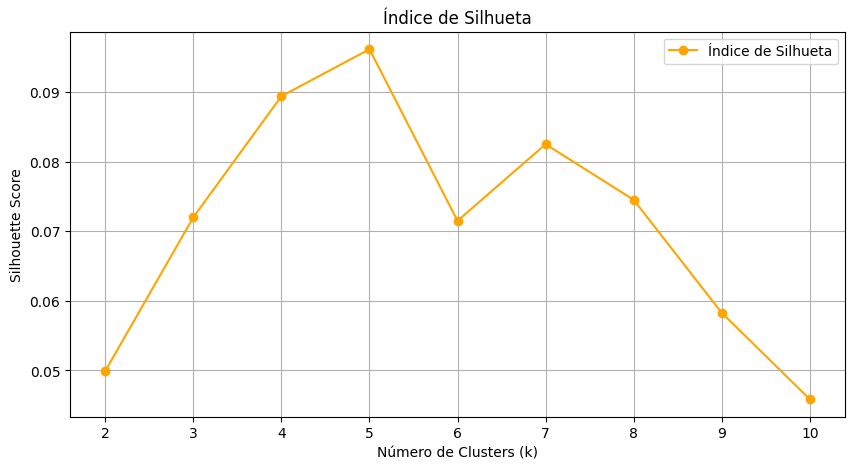

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

silhouette_scores = []
k_values = range(2, 11)

data_onehot = pd.get_dummies(data)

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(data_onehot)
    silhouette_scores.append(silhouette_score(data_onehot, kmeans.labels_))

optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"Valor ideal de k baseado no índice de silhueta: {optimal_k}")

plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker='o', label='Índice de Silhueta', color='orange')
plt.title("Índice de Silhueta")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid()
plt.legend()
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

def preprocess_text(text):

    words = text.split()
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    return ' '.join(words)

data['Anthem'] = data['Anthem'].apply(preprocess_text)

n_clusters = optimal_k
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', min_df=2, max_df=0.5)

X = vectorizer.fit_transform(data['Anthem'])

X

<190x1286 sparse matrix of type '<class 'numpy.float64'>'
	with 7538 stored elements in Compressed Sparse Row format>

In [ ]:
km = KMeans(n_clusters=optimal_k)
km.fit(X)

centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(n_clusters):
    print(f"Cluster {i}:", end=' ')
    for ind in centroids[i, :10]:
        print(terms[ind], end=' ')
    print()

data['Cluster'] = km.labels_


Cluster 0: country homeland flag long live glory let people world free 
Cluster 1: motherland let nation freedom people love peace glory liberty justice 
Cluster 2: great arise fatherland bless free let home people beloved heart 
Cluster 3: god save lord bless make brother shall hail africa defend 
Cluster 4: thy thee oh love thou liberty dear sun shall homeland 


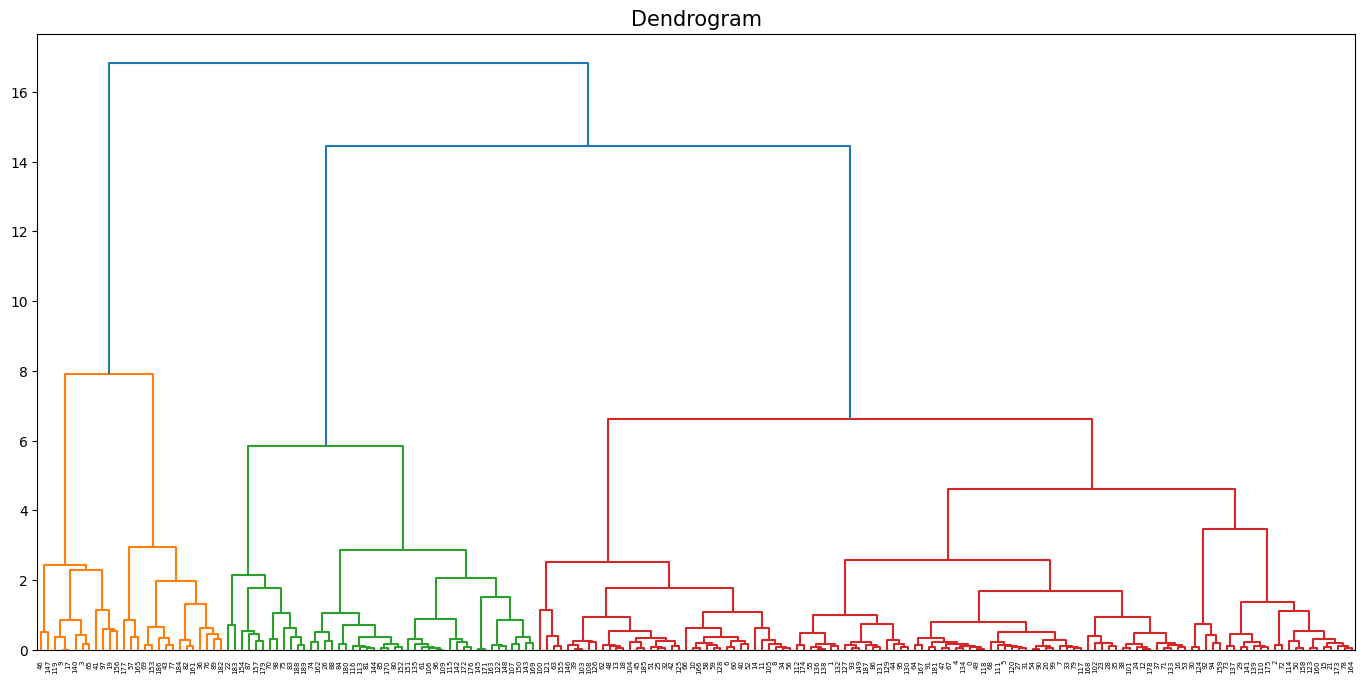

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

linkage_matrix = linkage(X_scaled, method='ward')
plt.figure(figsize=(17, 8))
dendro = dendrogram(linkage_matrix)
plt.title('Dendrogram', fontsize=15)
plt.show()


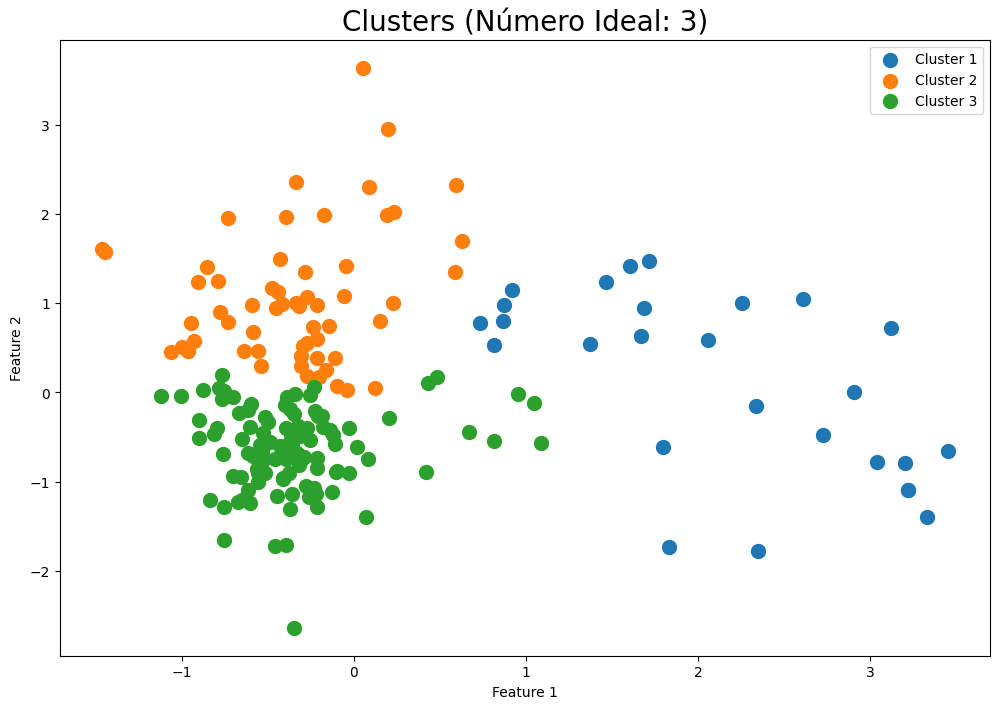

In [ ]:
optimal_kc = 3
agc = AgglomerativeClustering(n_clusters=optimal_kc, linkage='ward')
labels = agc.fit_predict(X_scaled)
plt.figure(figsize=(12, 8))

for i in range(optimal_kc):
    plt.scatter(X_scaled[labels == i, 0], X_scaled[labels == i, 1], label=f'Cluster {i+1}', s=100)

plt.legend(loc='best')
plt.title(f'Clusters (Número Ideal: {optimal_kc})', fontsize=20)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

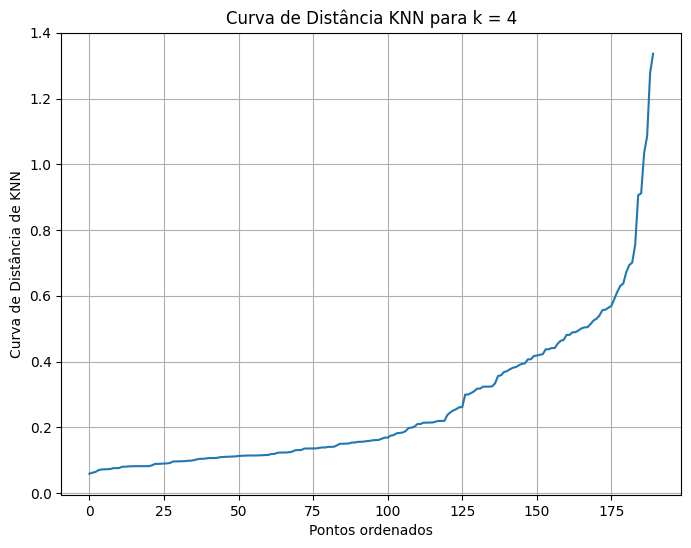

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
k = 4

neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(X_scaled)
distances, indices = neighbors.kneighbors(X_scaled)
distances = np.sort(distances[:, k-1], axis=0)


plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.xlabel("Pontos ordenados")
plt.ylabel("Curva de Distância de KNN")
plt.title(f"Curva de Distância KNN para k = {k}")
plt.grid()
plt.show()


Número de clusters: 4
Número de outliers: 9


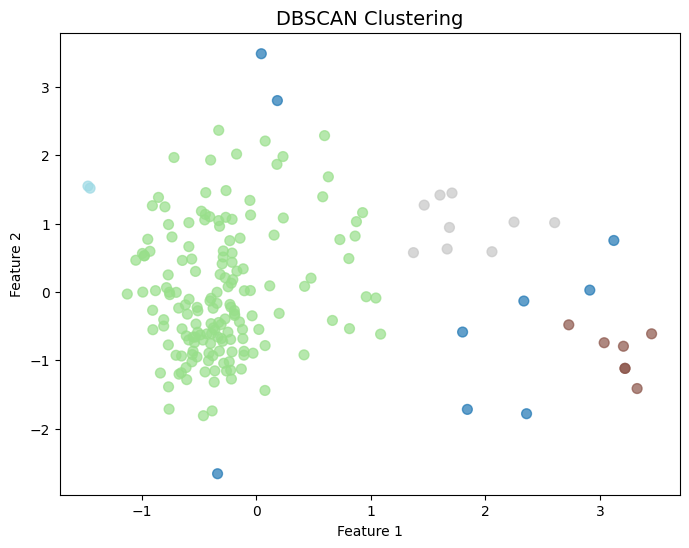

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=2)
labels = dbscan.fit_predict(X_scaled)

print(f'Número de clusters: {len(set(labels)) - (1 if -1 in labels else 0)}')
print(f'Número de outliers: {list(labels).count(-1)}')

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='tab20', s=50, alpha=0.7)

plt.title('DBSCAN Clustering', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')


plt.show()

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 4
lda = LatentDirichletAllocation(n_components=n_topics)
lda.fit(X)

def get_topics(lda_model, n_top_words):
    terms = vectorizer.get_feature_names_out()
    topics = {}
    for topic_idx, topic in enumerate(lda_model.components_):
        topic_words = [terms[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics[topic_idx] = topic_words
    return topics

topics = get_topics(lda, n_top_words=10)

for topic_id, words in topics.items():
    print(f"Tópico {topic_id}: {', '.join(words)}")


Tópico 0: treasure, stone, language, perpetually, shadow, sung, sleep, leaf, ripple, kingdom
Tópico 1: let, god, people, thy, country, free, nation, glory, homeland, love
Tópico 2: witness, lightning, thunder, protector, kingdom, rousing, stop, loudly, disappear, wake
Tópico 3: german, hail, light, thousand, thy, knew, graf, slain, divinely, thee


In [ ]:
from sklearn.decomposition import NMF
n_topics = 4
nmf = NMF(n_components=n_topics)
nmf.fit(X)

def get_topics(nmf_model, n_top_words):
    terms = vectorizer.get_feature_names_out()
    topics = {}
    for topic_idx, topic in enumerate(nmf_model.components_):
        topic_words = [terms[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics[topic_idx] = topic_words
    return topics

topics = get_topics(nmf, n_top_words=10)

for topic_id, words in topics.items():
    print(f"Tópico {topic_id}: {', '.join(words)}")

Tópico 0: homeland, country, glory, flag, shall, live, fatherland, world, long, free
Tópico 1: thy, thee, thou, hail, thine, love, liberty, light, art, restored
Tópico 2: bless, god, oh, lord, protect, nation, stand, free, island, peace
Tópico 3: let, people, arise, sing, great, unity, guinea, new, march, come
